In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import ta  # Thêm thư viện phân tích kỹ thuật
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from ta.trend import MACD

# 1️⃣ Tải dữ liệu
ticker = 'GOOG'
start = '2010-01-01'
end = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start, end)

# 2️⃣ Thêm các chỉ báo kỹ thuật
data["SMA_50"] = ta.trend.sma_indicator(data["Close"].squeeze(), window=50)
  # Đường trung bình 50 ngày
data["RSI_14"] = ta.momentum.rsi(data["Close"].squeeze(), window=14)

# data["MACD"] = macd_indicator.macd().values.ravel()


 # Chỉ số MACD

# Xóa các dòng có giá trị NaN
data.dropna(inplace=True)

# Chỉ sử dụng các cột cần thiết
features = ["Close", "SMA_50", "RSI_14"]
dataset = data[features]

# 3️⃣ Tiền xử lý dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(dataset)

lookback = 60  # Dùng 60 ngày trước để dự đoán
X, y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i-lookback:i])
    y.append(data_scaled[i][0])

X, y = np.array(X), np.array(y)

# 4️⃣ Chia tập train & test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[*********************100%***********************]  1 of 1 completed


In [29]:
# 5️⃣ Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')



/home/phung/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# 6️⃣ Huấn luyện mô hình
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0167 - val_loss: 0.0029
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 8.7324e-04 - val_loss: 0.0017
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 5.9805e-04 - val_loss: 0.0026
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 5.7990e-04 - val_loss: 0.0027
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 4.5553e-04 - val_loss: 0.0011


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
🔹 RMSE: 6.397712816688661
🔹 MAE: 4.96185480549727


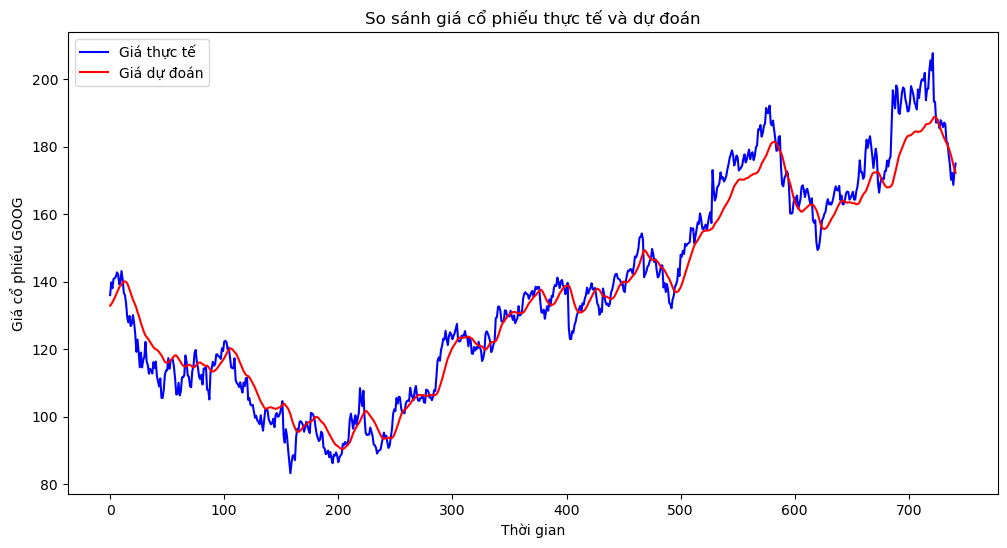

In [37]:
# 7️⃣ Dự đoán trên tập test
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(
    np.c_[y_test, np.zeros((len(y_test), scaler.n_features_in_ - 1))]
)[:, 0]

y_pred_inv = scaler.inverse_transform(
    np.c_[y_pred, np.zeros((len(y_pred), scaler.n_features_in_ - 1))]
)[:, 0]

# 8️⃣ Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'🔹 RMSE: {rmse}')
print(f'🔹 MAE: {mae}')

# 9️⃣ Vẽ biểu đồ so sánh giá thực tế & dự đoán
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Giá thực tế", color='blue')
plt.plot(y_pred_inv, label="Giá dự đoán", color='red')
plt.xlabel("Thời gian")
plt.ylabel("Giá cổ phiếu GOOG")
plt.legend()
plt.title("So sánh giá cổ phiếu thực tế và dự đoán")
plt.show()

In [54]:
# 🔟 Dự đoán 3 ngày tiếp theo
future_days = 3
last_60_days = data_scaled[-lookback:]  # Lấy 60 ngày gần nhất làm dữ liệu đầu vào
future_input = last_60_days.reshape(1, lookback, X.shape[2])
future_predictions = []

for _ in range(future_days):
    future_pred = model.predict(future_input)[0][0]  # Dự đoán giá trị tiếp theo
    future_predictions.append([future_pred])  # Đưa vào danh sách dự đoán

    # Cập nhật future_input để sử dụng giá trị dự đoán trong lần tiếp theo
    future_input = np.append(future_input[:, 1:, :], [[[future_pred, 0, 0]]], axis=1)

# ✅ Chuyển danh sách về numpy array để xử lý
future_predictions = np.array(future_predictions).reshape(-1, 1)

# ✅ Chuyển đổi giá trị dự đoán về dạng gốc
future_predictions_inv = scaler.inverse_transform(
    np.hstack((future_predictions, np.zeros((future_days, X.shape[2] - 1))))
)[:, 0]

# 📌 In kết quả dự đoán
print("\n📌 Dự đoán giá 3 ngày tiếp theo:")
for i, price in enumerate(future_predictions_inv, 1):
    print(f"📅 Ngày {i}: {price:.2f} USD")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

📌 Dự đoán giá 3 ngày tiếp theo:
📅 Ngày 1: 171.50 USD
📅 Ngày 2: 169.37 USD
📅 Ngày 3: 166.05 USD


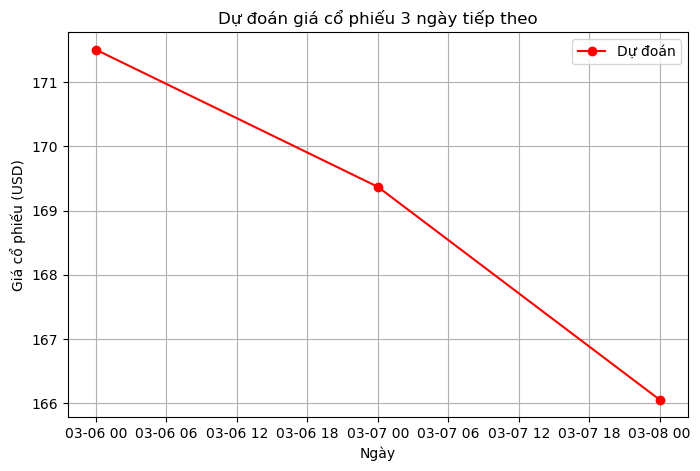

In [56]:
import matplotlib.pyplot as plt

# Danh sách ngày dự đoán (giả sử tiếp tục từ ngày cuối cùng trong dữ liệu)
last_date = data.index[-1]  # Ngày cuối cùng trong dữ liệu
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Vẽ biểu đồ dự đoán
plt.figure(figsize=(8, 5))
plt.plot(future_dates, future_predictions_inv, marker='o', linestyle='-', color='red', label='Dự đoán')

# Cấu hình biểu đồ
plt.xlabel("Ngày")
plt.ylabel("Giá cổ phiếu (USD)")
plt.title("Dự đoán giá cổ phiếu 3 ngày tiếp theo")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


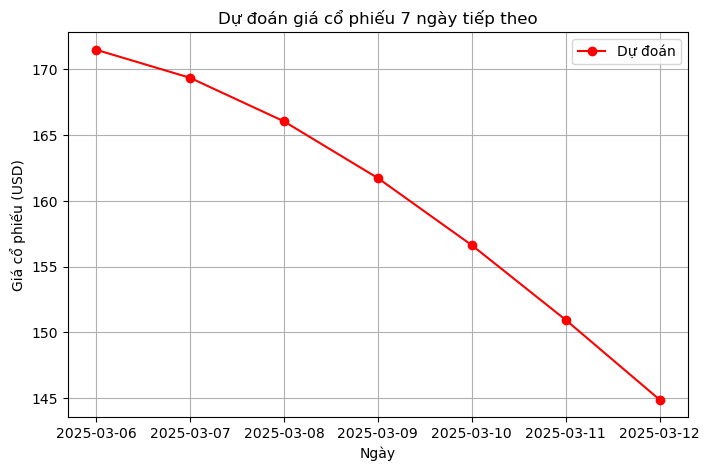

In [59]:
future_days = 7  # Dự đoán 7 ngày thay vì 3 ngày

# Lấy dữ liệu gần nhất để dự đoán
last_60_days = data_scaled[-lookback:]
future_input = last_60_days.reshape(1, lookback, X.shape[2])
future_predictions = []

# Vòng lặp dự đoán 7 ngày liên tiếp
for _ in range(future_days):
    future_pred = model.predict(future_input)[0][0]  # Dự đoán ngày tiếp theo
    future_predictions.append(future_pred)  # Lưu kết quả dự đoán

    # Cập nhật dữ liệu đầu vào cho lần dự đoán tiếp theo
    future_input = np.append(future_input[:, 1:, :], [[[future_pred] + [0] * (X.shape[2] - 1)]], axis=1)

# Chuyển giá trị dự đoán về dạng gốc (từ MinMaxScaler)
future_predictions_inv = scaler.inverse_transform(
    np.c_[future_predictions, np.zeros((len(future_predictions), X.shape[2] - 1))]
)[:, 0]

# ✅ Tạo danh sách ngày cho 7 ngày tương lai
last_date = data.index[-1]  # Ngày cuối cùng trong dữ liệu
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# ✅ Vẽ biểu đồ dự đoán
plt.figure(figsize=(8, 5))
plt.plot(future_dates, future_predictions_inv, marker='o', linestyle='-', color='red', label='Dự đoán')

# Cấu hình biểu đồ
plt.xlabel("Ngày")
plt.ylabel("Giá cổ phiếu (USD)")
plt.title("Dự đoán giá cổ phiếu 7 ngày tiếp theo")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()
